In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
from overlap import *  # bad practice
from IPython.display import display

from astropy.io import fits
from astropy.table import Table

import seaborn as sns
sns.set_context('poster')

import sklearn

from axial_ratio_comparison import cache_nsa, get_agn_catalog
from shared_utilities import plot_catalog, plot_catalog_overlap

In [2]:
# joint_catalog = Table(fits.getdata('/Volumes/external/decals/catalogs/dr5_nsa1_0_0_to_upload.fits'))
heckman = get_heckman_catalog(heckman_loc='/data/repos/find_agn/sdss_dr7_radiosources.cat')
galaxy_zoo = pd.read_csv('/data/galaxy_zoo/gz2/subjects/gz2_hart16.csv')

/Data/repos/find_agn/overlap.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table(heckman_loc, sep=r"\s*")
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2138: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/data/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/io/parsers.py:2140: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [3]:
new_dr7 = False
source_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2.fit'
cache_loc = '/data/galaxy_zoo/decals/catalogs/gal_info_dr7_v5_2_cache.csv'

In [4]:
def cache_dr7(source_loc, cache_loc):
    dr7 = Table(fits.getdata(source_loc))
    for col in dr7.colnames:
        dr7.rename_column(col, col.lower())
    bands = ['g', 'r', 'i']
    mag_cols = ['kcor_mag_{}'.format(band) for band in bands]
    for n in range(len(bands)):
        mag_col = mag_cols[n]
        dr7[mag_col] = [dr7[row]['kcor_mag'][n] for row in range(len(dr7))]
    useful_columns = ['ra','dec', 'z', 'release'] + mag_cols
    dr7[useful_columns].write(target_loc)

In [52]:
if new_dr7:
    cache_dr7(source_loc, cache_loc)
dr7 = pd.read_csv(cache_loc)

In [5]:
# plot_overlaps(joint_catalog, heckman)

In [10]:
new_nsa = False
nsa_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1.fits'
nsa_cache_loc = '/data/galaxy_zoo/decals/catalogs/nsa_v1_0_1_cached.csv'
if new_nsa:
    useful_nsa_columns = [
    'ra',
    'dec',
    'mag',
#     'bastokes',
#     'phistokes',
    'petro_ba50',
    'petro_phi50',
    'petro_ba90',
    'petro_phi90',
    'elpetro_mass',
    'elpetro_phi',
    'elpetro_flux_r',
    'elpetro_theta',
    ]
    useful_nsa_columns = list(map(lambda x: x.upper(), useful_nsa_columns))
    nsa = cache_nsa(nsa_loc, nsa_cache_loc, useful_nsa_columns)

In [53]:
nsa = pd.read_csv(nsa_cache_loc)

In [50]:
def enforce_physical_ra_limits(catalog):
    physical_catalog = catalog[(catalog['dec'] < 90.) & (catalog['dec'] > -90.)]
    print('Catalog reduced to {} from {} galaxies'.format(len(physical_catalog), len(catalog)))
    return physical_catalog

In [54]:
nsa = enforce_physical_ra_limits(nsa)
dr7 = enforce_physical_ra_limits(dr7)

Catalog reduced to 641409 from 641409 galaxies
Catalog reduced to 927551 from 927552 galaxies


## Match all catalogs to build useful features

### Match basic catalogs: DR7 and NSA

This isn't necessary, it just helps check where any mismatch occurs

In [55]:
dr7_and_nsa, dr7_no_nsa = match_galaxies_to_catalog_pandas(dr7, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(dr7_and_nsa), len(dr7_no_nsa)))

Galaxies matched: 587420. Galaxies missed: 340131.


Therefore DR7 and NSA are quite bad matches!

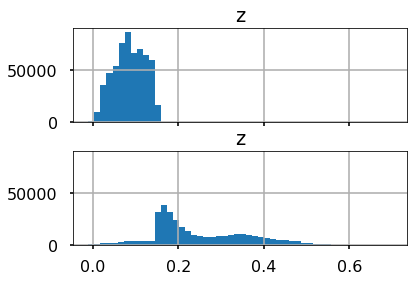

In [56]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa.hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa.hist('z', bins=50, ax=axes[1])

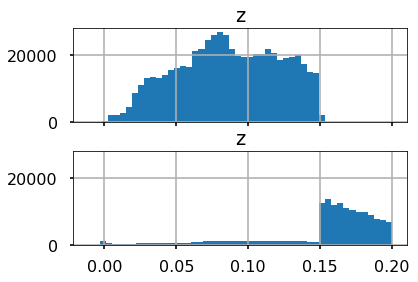

In [57]:
fig, axes = plt.subplots(2, sharex=True, sharey=True)
dr7_and_nsa[dr7_and_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[0])
a = dr7_no_nsa[dr7_no_nsa['z'] < 0.2].hist('z', bins=50, ax=axes[1])

Below is outdated - please ignore

The mismatch is almost completely due to redshift - NSA only goes to z = 0.15, but DR7 goes to z = 0.6. That's okay - we're only looking for fairly nearby galaxies with detectable bars

Basic catalogs (DR7 MPA-JHU for Heckman, NSA for Galaxy Zoo) disagree where galaxies are.

About (at most) half of this disagreement is because MPA_JHU is much deeper.

About (at least) half of this disagreement is unexplained

They disagree on galaxies which are very close (z < 0.012 or so). Otherwise, disagreement gradually increases with redshift - suggesting a centroid measurement error?  The matching radius I use is 10 arcseconds.

The DR13 tables here https://skyserver.sdss.org/dr13/en/help/docs/tabledesc.aspx include:
"SpecObjAll" - hopefully a complete joined (where possible) catalog between MPA and later work
"SpecObjInfo" - hopefully the MPA spectroscopic catalog, joinable to SpecObjAll with SpecObjID


http://home.strw.leidenuniv.nl/~jarle/SDSS/
https://wwwmpa.mpa-garching.mpg.de/SDSS/

### Check Heckman and DR7 match fairly well

In [63]:
heckman_and_dr7, heckman_no_dr7 = match_galaxies_to_catalog_pandas(heckman, dr7)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_and_dr7), len(heckman_no_dr7)))

Galaxies matched: 18286. Galaxies missed: 0.


Perfect - all Heckman radio sources are in DR7 , as expected - Heckman used DR7 to crossmatch for sources

### Check NSA and Galaxy Zoo match fairly well

In [58]:
nsa_and_gz, nsa_no_gz = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(nsa_and_gz), len(nsa_no_gz)))

Galaxies matched: 218759. Galaxies missed: 20936.


Yep, 90% match. 10% loss is most likely from radius cut.

### Match DR7-NSA-GZ to Heckman for AGN info

In [67]:
heckman_gz, heckman_only = match_galaxies_to_catalog_pandas(heckman, dr7_and_gz)
print('LERG remaining: {} of {}'.format(heckman_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_gz), len(heckman['lerg'])))

LERG remaining: 2565 of 9863
Galaxies matched: 5051. Galaxies missed: 18286.


The big drop here is probably because of the DR7-NSA mismatch - but it's not clear to me why it's a factor of 4, not 2ish

### Let's do it - link Heckman and DR7, GZ and NSA, then both

In [68]:
heckman_dr7, heckman_only = match_galaxies_to_catalog_pandas(heckman, dr7)
print('LERG remaining: {} of {}'.format(heckman_dr7['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(heckman_dr7), len(heckman)))

LERG remaining: 9863 of 9863
Galaxies matched: 18286. Galaxies missed: 18286.


In [70]:
gz_nsa, gz_only = match_galaxies_to_catalog_pandas(galaxy_zoo, nsa)
print('Galaxies matched: {}. Galaxies missed: {}.'.format(len(gz_nsa), len(gz_only)))

Galaxies matched: 218759. Galaxies missed: 20936.


In [71]:
gz_heckman, heckman_no_gz = match_galaxies_to_catalog_pandas(heckman_dr7, gz_nsa)
print('LERG remaining: {} of {}'.format(gz_heckman['lerg'].sum(), heckman_dr7['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(gz_heckman), len(heckman_no_gz)))

LERG remaining: 2565 of 9863
Galaxies remaining: 5051 of 13235


## Do Science

Make a new 'agn_type' column so Heckman's data is easier to work with

In [79]:
def get_agn_type(series):
    if series['herg'] == 1:
        return 'herg'
    elif series['lerg'] == 1:
        return 'lerg'
    else:
        return 'star-forming'

In [195]:
galaxies = gz_heckman.copy()
galaxies['p_bar'] = galaxies['t03_bar_a06_bar_debiased']
galaxies = galaxies.dropna(subset=['p_bar', 'petro_ba90'])
galaxies['agn_type'] = galaxies.apply(get_agn_type, axis=1)

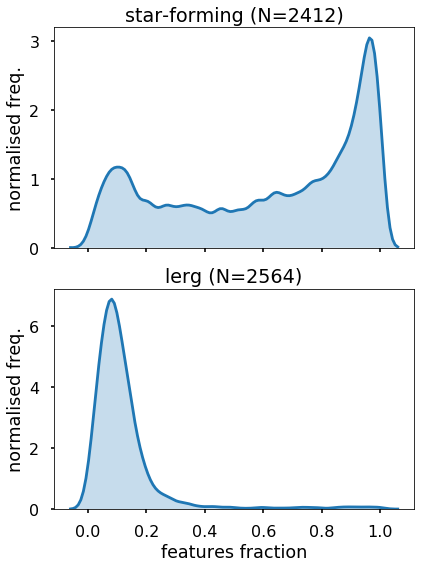

In [233]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[0], shade=True, bw=0.02)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['t01_smooth_or_features_a02_features_or_disk_fraction'], ax=axes[1], shade=True, bw=0.02)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('features fraction')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

Galaxies with LERGs, generally, are WAY less featured than star-forming galaxies. I think this might be a selection effect. Most galaxies are smooth, and so most AGN are smooth. But star-forming galaxies are generally featured. We can't select smooth non-AGN galaxies because we require radio sources. This would be more informative checked against the full GZ population.

I should plot a bunch of small random thumbnails of each to get a sense for what the different populations look like

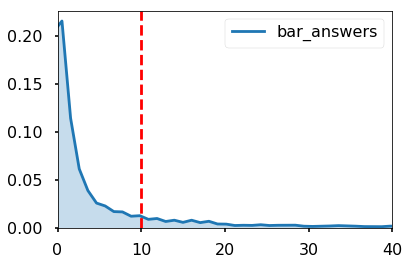

In [234]:
galaxies['bar_answers'] = galaxies['t03_bar_a06_bar_count'] + galaxies['t03_bar_a06_bar_count']
ax = sns.kdeplot(data=galaxies['bar_answers'], shade=True)
_ = ax.set_xlim([0, 40])
ax.axvline(10, color='r', linestyle='--')

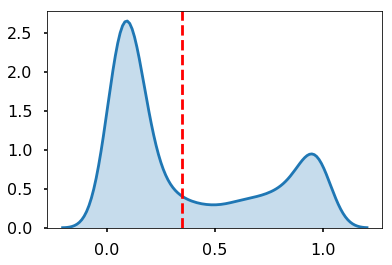

In [235]:
ax = sns.kdeplot(data=galaxies['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'], shade=True, legend=False)
ax.axvline(0.35, color='r', linestyle='--')

In [236]:
display(galaxies.columns.values)

array(['id1', 'id2', 'id3', 'ra_subject_subject', 'dec_subject_subject',
       'z_subject', 's_nvss', 'radclas', 's_first', 'off_first', 'rad_agn',
       'main_sample', 'lerg', 'herg', 'best_match',
       'sky_separation_subject', 'ra_subject', 'dec_subject', 'z',
       'release', 'kcor_mag_g', 'kcor_mag_r', 'kcor_mag_i',
       'sky_separation_subject', 'dr7objid', 'ra_subject', 'dec_subject',
       'rastring', 'decstring', 'sample', 'gz2_class',
       'total_classifications', 'total_votes',
       't01_smooth_or_features_a01_smooth_count',
       't01_smooth_or_features_a01_smooth_weight',
       't01_smooth_or_features_a01_smooth_fraction',
       't01_smooth_or_features_a01_smooth_weighted_fraction',
       't01_smooth_or_features_a01_smooth_debiased',
       't01_smooth_or_features_a01_smooth_flag',
       't01_smooth_or_features_a02_features_or_disk_count',
       't01_smooth_or_features_a02_features_or_disk_weight',
       't01_smooth_or_features_a02_features_or_disk_fract

In [237]:
def filter_for_pbar(df):
    # apply filters - keep only well-measured galaxies
    print(len(df))
    # > 10 answer 'is there a sign of a bar?
    df = df[df['t03_bar_a06_bar_count'] + df['t03_bar_a06_bar_count'] > 10]
    print(len(df))
    # p(features or disk) > 0.35?
    # not clear if these should be debiased
    df = df[df['t01_smooth_or_features_a02_features_or_disk_weighted_fraction'] > 0.35] 
    print(len(df))
    # p(not edge on) > 0.6?
    # not clear if these should be debiased
    df = df[df['t02_edgeon_a05_no_weighted_fraction'] > 0.6] 
    print(len(df))
    return df

In [238]:
galaxies = filter_for_pbar(galaxies)

5050
810
796
764


Only 15% have valid pbar measurements, as defined by Mel. This is mostly because quite few galaxies have > 10 answers to 'is there a bar?'. That's because about 2/3rds of people answer 'smooth' to 'featured or smooth?'. But why should we exclude 'smooth'? Isn't 'smooth' an indicator of the absence of a bar? Also remember that all galaxies are star-forming.

What do we know about AGN in galaxies which are smooth v featured?

### Investigate how agn type correlates with bar fraction

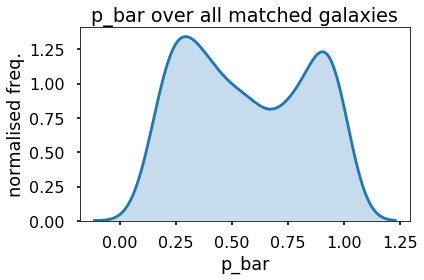

In [239]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=galaxies['p_bar'], ax=ax, shade=True)
ax.set_title('p_bar over all matched galaxies')
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

5
20
739


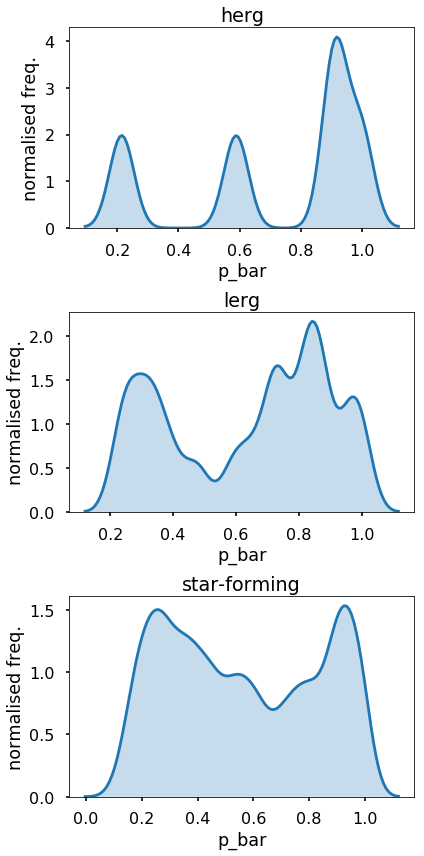

In [240]:
fig, axes = plt.subplots(3, figsize=(6, 12))
agn_types = ['herg', 'lerg', 'star-forming']
for n in range(3):
    agn_type = agn_types[n]
    selected_galaxies = galaxies[galaxies['agn_type'] == agn_type]
    ax = sns.kdeplot(data=selected_galaxies['p_bar'], ax=axes[n], shade=True, bw=0.04)
    ax.set_xlabel('p_bar')
    ax.set_ylabel('normalised freq.')
    ax.set_title(agn_type)
    print(len(selected_galaxies))
    ax.legend_.remove()
fig.tight_layout()

 For all classes, many more galaxies have p_bar = 0 than any other value (makes sense). Let's look at only lerg and star-forming, as we're down to 75 hergs.

The below is now outdated - possible bar cut no longer needed if we require face-on

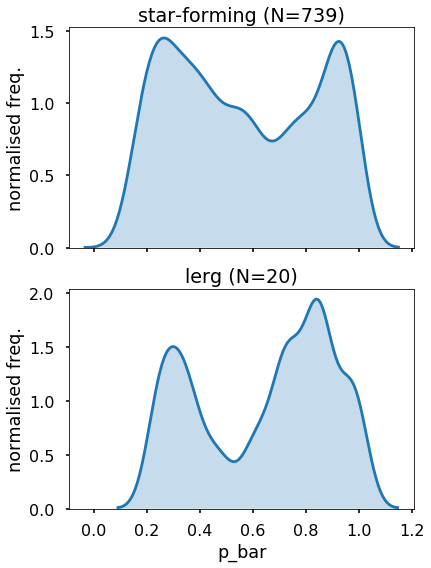

In [241]:
agn_types = ['lerg', 'star-forming']
possible_bar_cut = 0.1
lerg_possible_bar = galaxies[(galaxies['agn_type'] == 'lerg') & (galaxies['p_bar'] > possible_bar_cut)]
sf_possible_bar = galaxies[(galaxies['agn_type'] == 'star-forming') & (galaxies['p_bar'] > possible_bar_cut)]
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf_possible_bar['p_bar'], ax=axes[0], shade=True, bw=0.05)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf_possible_bar)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg_possible_bar['p_bar'], ax=axes[1], shade=True, bw=0.05)
ax.set_title('lerg (N={})'.format(len(lerg_possible_bar)))
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

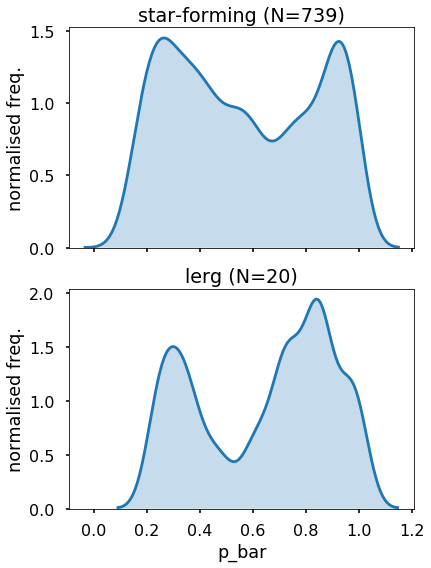

In [242]:
agn_types = ['lerg', 'star-forming']
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
fig, axes = plt.subplots(2, figsize=(6, 8), sharex=True)
ax = sns.kdeplot(data=sf['p_bar'], ax=axes[0], shade=True, bw=0.05)
ax.legend_.remove()
ax.set_title('star-forming (N={})'.format(len(sf)))
ax.set_ylabel('normalised freq.')
ax = sns.kdeplot(data=lerg['p_bar'], ax=axes[1], shade=True, bw=0.05)
ax.set_title('lerg (N={})'.format(len(lerg)))
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend_.remove()
fig.tight_layout()

Before controlling for mass and colour:
    * lergs are smoothly slightly less frequent with increasing pbar, until pbar = 0.7ish where there is possible turnover
    * star-forming galaxies are noisily distributed at all p_bar

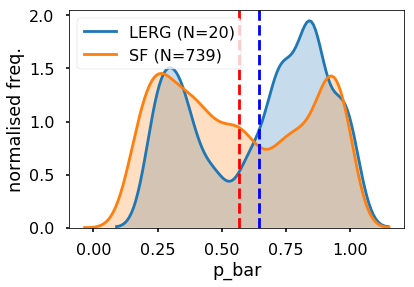

In [432]:
ax = sns.kdeplot(data=lerg_possible_bar['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf_possible_bar['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg_possible_bar)), 
    'SF (N={})'.format(len(sf_possible_bar))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf['p_bar'].mean(), color='r', linestyle='--')

If I had a bucket of galaxies where half were SF and half were LERG:
    * low pbar would be mostly SF
    * mid pbar would be mostly lerg
    * high pbar would be a similar fraction of each

### Control for mass and colour

What's the general distribution of mass and colour?

In [244]:
galaxies['u-r'] = galaxies['elpetro_flux_u'] - galaxies['elpetro_flux_r']
galaxies['norm_colour'] = galaxies['u-r']/galaxies['u-r'].mean()
galaxies['log_colour'] = np.log10(1 + galaxies['norm_colour'] - galaxies['norm_colour'].min())

galaxies['mass'] = galaxies['elpetro_mass']
galaxies['log_mass'] = np.log10(galaxies['elpetro_mass'])

I thought that galaxies were supposed to be bimodel in colour. That's not really true with the u-r fluxes of my sample. Maybe I should follow the literature and use mag colours.

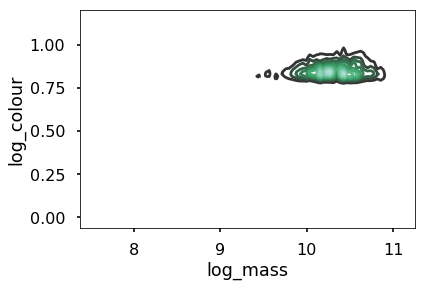

In [250]:
ax = sns.kdeplot(data=galaxies['log_mass'], data2=galaxies['log_colour'],bw=0.02)

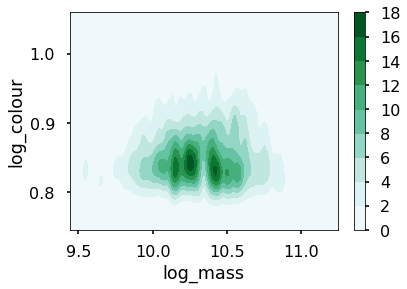

In [251]:
selected_galaxies = galaxies[(galaxies['log_mass'] > 9.5) &  (galaxies['log_colour'] < 1.0) & (galaxies['log_colour'] > 0.7)]
ax = sns.kdeplot(data=selected_galaxies['log_mass'], data2=selected_galaxies['log_colour'], shade=True, cbar=True, bw=0.02)

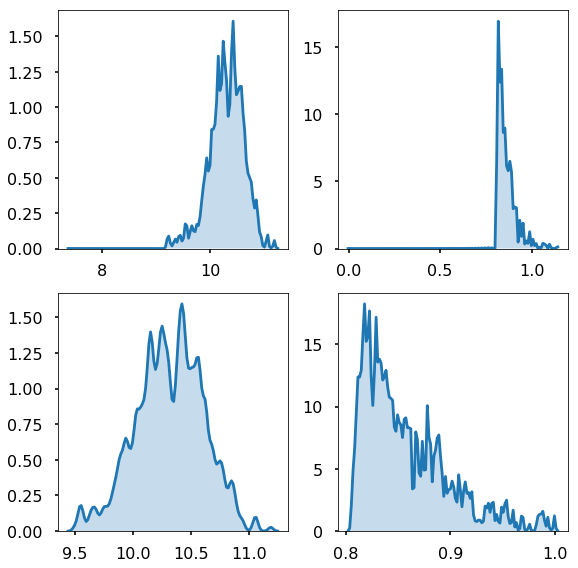

In [252]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = sns.kdeplot(data=galaxies['log_mass'], shade=True, bw=0.02, ax=axes[0][0], legend=False)
ax = sns.kdeplot(data=galaxies['log_colour'], shade=True, bw=0.001, ax=axes[0][1], legend=False)
ax = sns.kdeplot(data=selected_galaxies['log_mass'], shade=True, bw=0.02, ax=axes[1][0], legend=False)
ax = sns.kdeplot(data=selected_galaxies['log_colour'], shade=True, bw=0.001, ax=axes[1][1], legend=False)
fig.tight_layout()

How are the mass and colour distributions different for LERG and SF?

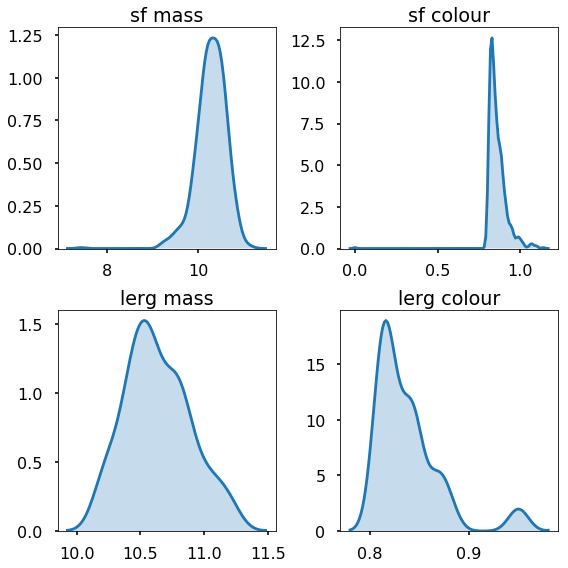

In [272]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
ax = sns.kdeplot(data=sf['log_mass'], shade=True, bw=0.1, ax=axes[0][0], legend=False)
ax.set_title('sf mass')
ax = sns.kdeplot(data=sf['log_colour'], shade=True, bw=0.01, ax=axes[0][1], legend=False)
ax.set_title('sf colour')
ax = sns.kdeplot(data=lerg['log_mass'], shade=True, bw=0.1, ax=axes[1][0], legend=False)
ax.set_title('lerg mass')
ax = sns.kdeplot(data=lerg['log_colour'], shade=True, bw=0.01, ax=axes[1][1], legend=False)
ax.set_title('lerg colour')
fig.tight_layout()

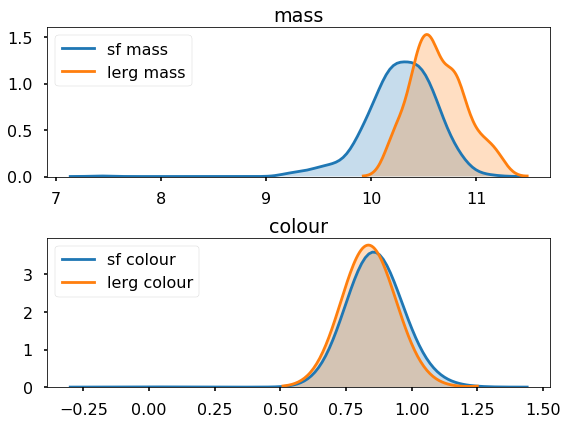

In [397]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
lerg = galaxies[galaxies['agn_type'] == 'lerg']
sf = galaxies[galaxies['agn_type'] == 'star-forming']
ax = sns.kdeplot(data=sf['log_mass'], shade=True, bw=0.1, ax=axes[0], legend=False)
ax = sns.kdeplot(data=lerg['log_mass'], shade=True, bw=0.1, ax=axes[0], legend=False)
ax.set_title('mass')
ax.legend(['sf mass', 'lerg mass'])
ax = sns.kdeplot(data=sf['log_colour'], shade=True, bw=0.1, ax=axes[1], legend=False)
ax = sns.kdeplot(data=lerg['log_colour'], shade=True, bw=0.1, ax=axes[1], legend=False)
ax.legend(['sf colour', 'lerg colour'])
ax.set_title('colour')
fig.tight_layout()

### Compare bar-ness for a mass-matched sample

In [328]:
# bins = np.arange(start=9, stop=13, step=0.5)

# # find target bin values
# bin_values, _ = np.histogram(lerg['log_mass'], bins=bins)
# print(bin_values)

# # find which bin each star-forming galaxy would be in (aka class label)
# sf['mass_class'] = np.digitize(sf['log_mass'], bins)
# sf['mass_class'] = sf['mass_class'].apply(lambda x: bins[x-1])

# from sklearn.model_selection import StratifiedKFold

# result = list(StratifiedKFold(n_splits=5, shuffle=True).split(np.zeros(len(sf)), (sf['mass_class']*10).astype(int)))
# train_indices = result[0][0]
# test_indices = result[0][1]
# print(train_indices, test_indices)


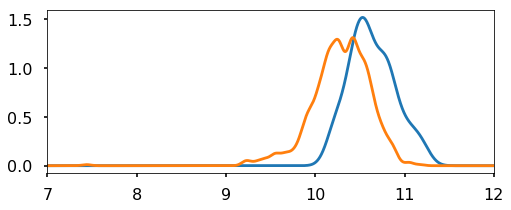

In [447]:
from scipy.stats import gaussian_kde

lerg_kde = gaussian_kde(lerg['log_mass'], bw_method=0.4)
fig, ax = plt.subplots(1, figsize=(8, 3))
ax.plot(np.arange(7, 13, 0.001), lerg_kde.evaluate(np.arange(7, 13, 0.001)))  # check it's working
ax.set_xlim([7, 12])

sf_kde = gaussian_kde(sf['log_mass'], bw_method=0.15)
ax.plot(np.arange(7, 13, 0.001), sf_kde.evaluate(np.arange(7, 13, 0.001)))  # check it's working

In [448]:
sf['resample_p'] = lerg_kde.evaluate(sf['log_mass']) / sf_kde.evaluate(sf['log_mass'])
sf['resample_p'] = sf['resample_p'] / sf['resample_p'].mean()
# draw from the distribution, with expectation num of...?
sf_sampled = sf.sample(len(lerg)*1000, replace=True, weights=sf['resample_p'])
# sf_sampled = sf[sf['resample_p'] > np.random.rand(len(sf))]

/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/data/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


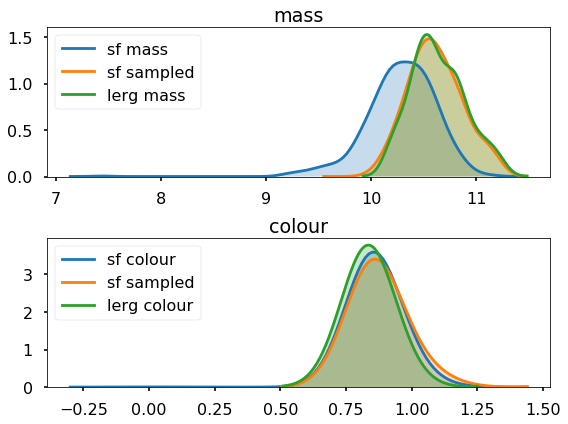

In [449]:
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
ax = sns.kdeplot(data=sf['log_mass'], shade=True, bw=0.1, ax=axes[0], legend=False)
ax = sns.kdeplot(data=sf_sampled['log_mass'], shade=True, bw=0.1, ax=axes[0], legend=False)
lerg_mass_ax = sns.kdeplot(data=lerg['log_mass'], shade=True, bw=0.1, ax=axes[0], legend=False)
lerg_mass_ax.set_title('mass')
lerg_mass_ax.legend(['sf mass', 'sf sampled', 'lerg mass'])
ax = sns.kdeplot(data=sf['log_colour'], shade=True, bw=0.1, ax=axes[1], legend=False)
ax = sns.kdeplot(data=sf_sampled['log_colour'], shade=True, bw=0.1, ax=axes[1], legend=False)
ax = sns.kdeplot(data=lerg['log_colour'], shade=True, bw=0.1, ax=axes[1], legend=False)
ax.legend(['sf colour', 'sf sampled', 'lerg colour'])
ax.set_title('colour')
fig.tight_layout()

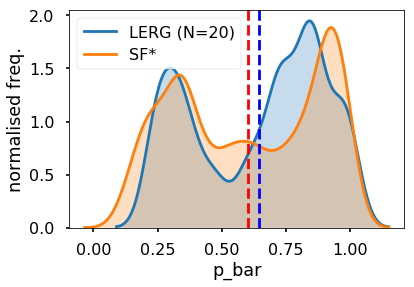

In [450]:
ax = sns.kdeplot(data=lerg['p_bar'], shade=True, bw=0.05, legend=False)
ax = sns.kdeplot(data=sf_sampled['p_bar'], shade=True, bw=0.05, legend=False)
ax.set_xlabel('p_bar')
ax.set_ylabel('normalised freq.')
ax.legend([
    'LERG (N={})'.format(len(lerg)), 
    'SF* '.format(len(sf_sampled))
])
ax.axvline(lerg['p_bar'].mean(), color='b', linestyle='--')
ax.axvline(sf_sampled['p_bar'].mean(), color='r', linestyle='--')

### Investigate how AGN type correlates with p_bar and inclination angle

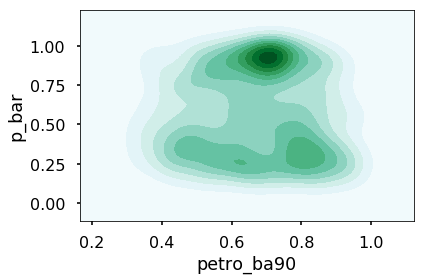

In [182]:
fig, ax = plt.subplots()
ax = sns.kdeplot(data=galaxies['petro_ba90'], data2=galaxies['p_bar'], ax=ax, shade=True)
fig.tight_layout()

20
739


IndexError: list index out of range

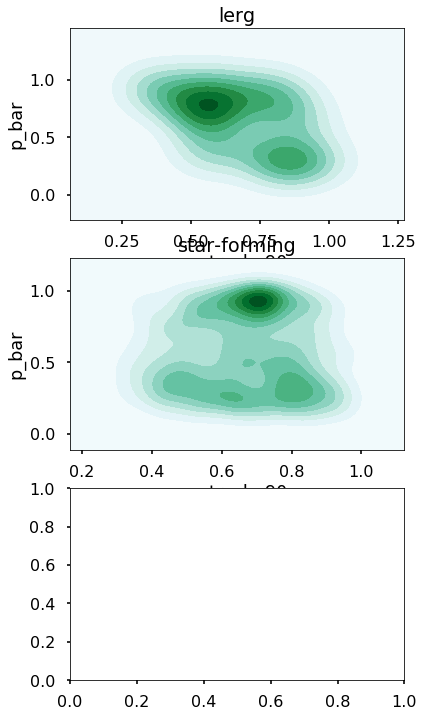

In [183]:
fig, axes = plt.subplots(3, figsize=(6, 12))
for n in range(3):
    agn_type = agn_types[n]
    selected_galaxies = galaxies[galaxies['agn_type'] == agn_type]
    ax = sns.kdeplot(data=selected_galaxies['petro_ba90'], data2=selected_galaxies['p_bar'], ax=axes[n], shade=True)
    ax.set_title(agn_type)
    print(len(selected_galaxies))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(3, figsize=(8, 14))
for n in range(3):
    ax = axes[n]
    agn_type = agn_types[n]
    selected_galaxies = galaxies[galaxies['agn_type'] == agn_type]
    ax.set_title(agn_type)
    ax.scatter(selected_galaxies['petro_ba90'], selected_galaxies['p_bar'], s=1.)
    print(len(selected_galaxies))
fig.tight_layout()

In [82]:
plot_catalog(heckman, filename='heckman_footprint')
plot_catalog(nsa, filename='nsa_footprint')
plot_catalog_overlap(heckman, nsa.sample(len(heckman)), legend=['heckman', 'nsa'], filename='nsa_heckman_overlap')
plot_catalog_overlap(heckman_nsa, heckman_only, legend=['matched', 'missed'], filename='nsa_heckman_matches')
# there are no heckman galaxies (red) outside the sdsss footprint(blue), as expected
# the mismatch happens within the footprint on ra/dec

/Data/repos/find_agn/shared_utilities.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  a_coords['catalog'] = legend[0]
/Data/repos/find_agn/shared_utilities.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  b_coords['catalog'] = legend[1]


In [84]:
# example_miss = heckman_only.iloc[5]
# ra = example_miss['ra']
# dec = example_miss['dec']
# print(ra)
# print(dec)
# print('http://www.legacysurvey.org/viewer?ra={}&dec={}&zoom=14&layer=decals-dr5'.format(ra, dec))

### Match DR7-NSA to Galaxy Zoo for bar info

In [61]:
dr7_and_gz, dr7_no_gz = match_galaxies_to_catalog_pandas(galaxy_zoo, dr7_and_nsa)
print('Galaxies remaining: {}. Galaxies missed: {}.'.format(len(dr7_and_gz), len(dr7_no_gz)))

Galaxies remaining: 217577. Galaxies missed: 22118.


As expected, 10% drop from the NSA-GZ slight mismatch. Still doing well.

In [94]:
heckman_nsa_gz, no_gz = match_galaxies_to_catalog_pandas(heckman_nsa, galaxy_zoo)
print('LERG remaining: {} of {}'.format(heckman_nsa_gz['lerg'].sum(), heckman['lerg'].sum()))
print('Galaxies remaining: {} of {}'.format(len(heckman_nsa_gz), len(heckman['lerg'])))

LERG remaining: 3587 of 9863
Galaxies remaining: 6407 of 18286


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11f2de630>], dtype=object)

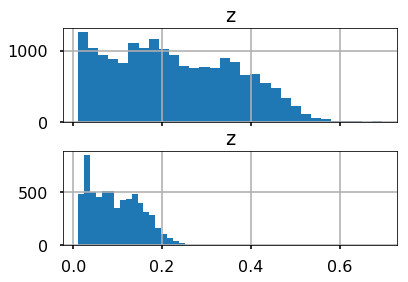

In [93]:
fig, axes = plt.subplots(2, sharex=True)
heckman_nsa.hist('z', bins=30, ax=axes[0])
heckman_nsa_gz.hist('z', bins=30, ax=axes[1])

In [ ]:
# heckman_decals, heckman_only = match_galaxies_to_catalog_pandas(heckman, joint_catalog[useful_nsa_columns].to_pandas())
# # TODO plot heckman_only
# print('LERG remaining: {} of {}'.format(heckman_decals['lerg'].sum(), heckman['lerg'].sum()))
# print('Galaxies remaining: {} of {}'.format(len(heckman_decals), len(heckman['lerg'])))

In [ ]:
# heckman_decals_gz, _ = match_galaxies_to_catalog_pandas(heckman_decals, galaxy_zoo)
# print('LERG remaining: {} of {}'.format(heckman_decals_gz['lerg'].sum(), heckman['lerg'].sum()))
# print('Galaxies remaining: {} of {}'.format(len(heckman_decals_gz), len(heckman['lerg'])))

In [11]:
print(heckman_nsa_gz.columns.values)

['id1' 'id2' 'id3' 'ra_subject' 'dec_subject' 'z' 's_nvss' 'radclas'
 's_first' 'off_first' 'rad_agn' 'main_sample' 'lerg' 'herg' 'best_match'
 'sky_separation' 'ra_subject' 'dec_subject' 'mag' 'petro_ba50'
 'petro_phi50' 'petro_ba90' 'petro_phi90' 'elpetro_mass' 'elpetro_phi'
 'elpetro_flux_r' 'elpetro_theta' 'elpetro_flux_f' 'elpetro_flux_n'
 'elpetro_flux_u' 'elpetro_flux_g' 'elpetro_flux_r.1' 'elpetro_flux_i'
 'elpetro_flux_z' 'dr7objid' 'ra' 'dec' 'rastring' 'decstring' 'sample'
 'gz2_class' 'total_classifications' 'total_votes'
 't01_smooth_or_features_a01_smooth_count'
 't01_smooth_or_features_a01_smooth_weight'
 't01_smooth_or_features_a01_smooth_fraction'
 't01_smooth_or_features_a01_smooth_weighted_fraction'
 't01_smooth_or_features_a01_smooth_debiased'
 't01_smooth_or_features_a01_smooth_flag'
 't01_smooth_or_features_a02_features_or_disk_count'
 't01_smooth_or_features_a02_features_or_disk_weight'
 't01_smooth_or_features_a02_features_or_disk_fraction'
 't01_smooth_or_featu